# 7章 畳み込みニューラルネットワーク

CNNキーワード

- Convolution
  - フィルター (カーネル)
  - パディング
  - ストライド
- Pooling
  - Maxプーリング
  - Averageプーリング

畳み込み演算では、
次元(N, C, H, W)の入力データに対し、次元(FN, C, FH, FW)のフィルターを適用する。
すると、次元(FN, OH, OW)の出力データを得られる。
さらに、次元(FN, 1, 1)のバイアスを加算し、畳み込み層の最終的な出力データとする。

```
N…バッチサイズ
C…チャンネル数
H…入力高さ
W…入力幅
FN…フィルター数
FH…フィルター高さ
FW…フィルター幅
OH…出力高さ
OW…出力幅
```


## 7.4 Convolution／Poolingレイヤの実装

CNNではデータ数、チャンネル数、入力画像の高さ、横幅の４次元のデータを扱うことになる。
真面目に実装するとfor文を幾重にも重ねた実装になるが、そうすると最適化された行列計算ライブラリの恩恵を受けることができない。

実際にはNumPyの `im2col` 関数 (image to column) を利用して計算を行う。
具体的には、入力データのフィルターを適用する領域を横方向に1列に展開する。

図7-18

ストライドが小さいほど展開された結果の列数が増えていく。

あとはフィルターも1列に展開して、行列の積を計算すればよい。すなわち、全結合層のAffineレイヤでの処理に帰着される。

図7-19

得られた結果は適切な形状に整形(reshape)する。


### 7.4.3 Convolutionレイヤの実装

`im2col` は以下のインタフェースを持つ

```
im2col(input_data, filter_h, filter_w, stride=1, pad=0)
```

実際に使うと以下のようになる

In [4]:
import numpy as np
import sys, os
sys.path.append(os.pardir)
from common.util import im2col

x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5)
print(col1.shape) # (9, 75)

x2 = np.random.rand(10, 3, 7, 7) # 10個のデータ
col2 = im2col(x2, 5, 5)
print(col2.shape) # (90, 75)

(9, 75)
(90, 75)


col1はフィルターの適用回数が9回なので(9, 75)が得られる。col2はデータ数が10個あるので、10倍の(90, 75)となる。

この `im2col` を使って畳み込み層を実装する。

In [5]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_w = self.W.reshape(FN, -1).T # フィルターの展開
        out = np.dot(col, col_w) + self.b
        
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        return out

reshapeは-1を指定すると多次元配列の要素数の辻褄が合うように要素数をまとめてくれる。
たとえば、(10, 3, 5, 5)の形状の配列はreshape(10, -1)とすると、(10, 75)の形状の配列に整形される。

transposeは多次元配列の軸の順番を入れ替える関数となっている。

逆伝播の実装については、 `im2col` の逆の処理として `col2im` という関数を利用する。あとはAffineレイヤと同じようにして実装できる。
具体的な実装は[common/layer.py](https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/common/layers.py#L232-L243)にある。

### 7.4.4 Poolingレイヤの実装

プーリング層の実装も畳み込み層と同じく `im2col` を使って入力データを展開する。
ただし、畳み込み層のときはチャンネルも含めて展開したのに対し、プーリング層ではチャンネル方向には独立に展開する。

図7-21

プーリング層の実装は以下のようになる。

In [13]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # 展開
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        
        # 最大値
        out = np.max(col, axis=1)
        # 整形
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        return out

図7-22

プーリング層のbackward処理については省略する。ReLUレイヤの実装で使ったmaxの逆伝播が参考になる。
具体的な実装は[common/layer.py](https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/common/layers.py#L273-L284)で確認できる。


## 7.5 CNNの実装

実装したConvolutionレイヤとPoolingレイヤを組み合わせて、手書き数字認識を行うCNNを組み立てる。

図7-23

上図のネットワーク構成をSimpleConvNetという名前のクラスで実装する。まず、初期化は次の引数を取る。

- `input_dim` 入力データの次元(チャンネル、高さ、幅）
- `conv_param` 畳み込み層のハイパーパラメータ（ディクショナリ）
  - `filter_num` フィルターの数
  - `filter_size` フィルターのサイズ
  - `stride` ストライド
  - `pad` パディング
- `hidden_size` 隠れ層（全結合層）のニューロンの数
- `output_size` 出力層（全結合層）のニューロンの数
- `weight_init_std` 初期化の際の重みの標準偏差

初期化処理としては、

1. 引数をローカル変数に展開し、畳み込み層の出力サイズを計算する。
2. 重みパラメータの初期化を行う
3. OrderedDictにレイヤを格納していく

といった処理を行う。推論処理の実装は4章, 5章で行ったように、OrderedDictをループさせてforward処理を次々と続けて実行すれば良い。

一連の実装は[simple_convnet.py](https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/ch07/simple_convnet.py)で確認できる。

このSimpleConvNetでMNISTデータセットを学習させてみる。

train loss:2.29953694674
=== epoch:1, train acc:0.161, test acc:0.126 ===
train loss:2.29913894531
train loss:2.29358178118
train loss:2.29300955787
train loss:2.28278951739
train loss:2.27093353163
train loss:2.25869370089
train loss:2.25442676236
train loss:2.24276809429
train loss:2.22110834226
train loss:2.15940718805
train loss:2.15229796109
train loss:2.10483446093
train loss:2.07239059178
train loss:2.0244185775
train loss:2.02078209405
train loss:1.8839600657
train loss:1.82697792103
train loss:1.81216598136
train loss:1.64560815809
train loss:1.62646856759
train loss:1.56692090302
train loss:1.36250234473
train loss:1.32139641136
train loss:1.31976465563
train loss:1.26868609014
train loss:1.05904516049
train loss:1.08919732989
train loss:0.980220923277
train loss:0.943153649003
train loss:1.00627969381
train loss:0.829092455805
train loss:0.798175531077
train loss:0.790877439699
train loss:0.804054570948
train loss:0.775862845484
train loss:0.877045409207
train loss:0.7097264

train loss:0.189562387803
train loss:0.156041332927
train loss:0.455848322907
train loss:0.27832979601
train loss:0.219123639237
train loss:0.301352159203
train loss:0.185337097528
train loss:0.211195159793
train loss:0.16519577879
train loss:0.124447747054
train loss:0.262764216789
train loss:0.238213016686
train loss:0.182624982669
train loss:0.290577486634
train loss:0.125826556367
train loss:0.142000512987
train loss:0.124878120057
train loss:0.0741215864148
train loss:0.161734018841
train loss:0.162079492568
train loss:0.17511003401
train loss:0.279554047238
train loss:0.256697997459
train loss:0.233060018475
train loss:0.135648926722
train loss:0.139458581474
train loss:0.242158854765
train loss:0.22612611681
train loss:0.141840097349
train loss:0.0925378511598
train loss:0.139928612747
train loss:0.197932537327
train loss:0.118878821118
train loss:0.167440181902
train loss:0.105354159683
train loss:0.172923434077
train loss:0.0935584598738
train loss:0.203950809582
train loss:0.

train loss:0.0757763476757
train loss:0.125162504791
train loss:0.057352000647
train loss:0.120958713259
train loss:0.123985416095
train loss:0.153528127719
train loss:0.0859695992008
train loss:0.185984340147
train loss:0.0261094267974
train loss:0.116125704576
train loss:0.0509155141938
train loss:0.0744833850471
train loss:0.0746378053609
train loss:0.0726202029935
train loss:0.126646797163
train loss:0.0894153362978
train loss:0.13058167136
train loss:0.0739770960421
train loss:0.12805659076
train loss:0.0805639070247
train loss:0.21083771855
train loss:0.0583063869865
train loss:0.0857142756063
train loss:0.152837974614
train loss:0.106073023447
train loss:0.0927772786724
train loss:0.22870562034
train loss:0.0204125845312
train loss:0.130173834425
train loss:0.160702003852
train loss:0.0842807015359
train loss:0.0500505676123
train loss:0.0921162511184
train loss:0.112638813534
train loss:0.0607818830161
train loss:0.0927507912981
train loss:0.126674794947
train loss:0.1524270520

train loss:0.10071768174
train loss:0.0557264921699
train loss:0.0776313474687
train loss:0.228830132617
train loss:0.0549116030946
train loss:0.137765933451
train loss:0.133719560027
train loss:0.250542256526
train loss:0.0982757306222
train loss:0.0514015429393
train loss:0.0639723231853
train loss:0.0813212612527
train loss:0.0405512959595
train loss:0.0544154957337
train loss:0.0486516646134
train loss:0.0559068464729
train loss:0.09209993664
train loss:0.0447477055329
train loss:0.0970729372281
train loss:0.0458474818258
train loss:0.0395139969008
train loss:0.0849069079416
train loss:0.121252995313
train loss:0.0961315284096
train loss:0.0500394877871
train loss:0.117351639299
train loss:0.0950391887297
train loss:0.0629177131789
train loss:0.0396558551072
train loss:0.152330413537
train loss:0.121111769842
train loss:0.0236452644114
train loss:0.0443709017212
train loss:0.101413327715
train loss:0.103253319748
train loss:0.0453990061124
train loss:0.132703508325
train loss:0.080

train loss:0.0300639114058
train loss:0.0419987075985
train loss:0.0466413960461
train loss:0.0726629419884
train loss:0.0855875461411
train loss:0.0371512569194
train loss:0.0317088817725
train loss:0.0534491544743
train loss:0.127726353684
train loss:0.0603008568533
train loss:0.0581636556597
train loss:0.051275642616
train loss:0.0484439651325
train loss:0.0690273113166
train loss:0.0485205544047
train loss:0.109395995758
train loss:0.0257610928151
train loss:0.0453591908839
train loss:0.172010754472
train loss:0.0658349395973
train loss:0.0244991674684
train loss:0.0921216968239
train loss:0.0302175946491
train loss:0.0182751215138
train loss:0.0454042224938
train loss:0.0702155306421
train loss:0.0437453317921
train loss:0.0526108527687
train loss:0.0596743753056
train loss:0.0601977617691
train loss:0.0489140857436
train loss:0.0826093185766
train loss:0.0511388928184
train loss:0.0464316369788
train loss:0.0262674332093
train loss:0.0748506866704
train loss:0.0301823971766
train

train loss:0.048798878001
train loss:0.0249825300982
train loss:0.0700422698185
train loss:0.0371707595266
train loss:0.0715268691645
train loss:0.025803360624
train loss:0.0743497591432
train loss:0.0265359629387
train loss:0.0649590374608
train loss:0.0844379506176
train loss:0.05032502492
train loss:0.101803592067
train loss:0.0271191507709
train loss:0.126147099922
train loss:0.0308354646319
train loss:0.0440628322111
train loss:0.0247374966685
train loss:0.0494291177818
train loss:0.0269862096362
train loss:0.0887657228562
train loss:0.0247403988329
train loss:0.103354868486
train loss:0.0333014258096
train loss:0.0596313253175
train loss:0.0783639365435
train loss:0.0634395240588
train loss:0.0321935055412
train loss:0.065375582616
train loss:0.0475510223661
train loss:0.0242757667768
train loss:0.106303211391
train loss:0.101259629942
train loss:0.0296394385369
train loss:0.0151561329327
train loss:0.0559527398472
train loss:0.0730035409196
train loss:0.075687787809
train loss:0

train loss:0.0195042063149
train loss:0.0233858155432
train loss:0.0111041982606
train loss:0.026503400855
train loss:0.0328719749581
train loss:0.0506435292677
train loss:0.0777056634143
train loss:0.0607166275607
train loss:0.00968597868283
train loss:0.0150451684638
train loss:0.0156886755384
train loss:0.0208350097131
train loss:0.0164784650134
train loss:0.140441580972
train loss:0.126416302232
train loss:0.0197741977865
train loss:0.0274170602912
train loss:0.010091249638
train loss:0.0494587022812
train loss:0.0130987650616
train loss:0.0661757069852
train loss:0.0448315773894
train loss:0.00901944906258
train loss:0.0842128551189
train loss:0.0357982094473
train loss:0.0519892507713
train loss:0.041957747963
train loss:0.0739913460282
train loss:0.0364191540704
train loss:0.0171905191349
train loss:0.0209127197602
train loss:0.0198215272831
train loss:0.0784019716486
train loss:0.0599383712037
train loss:0.0813553865096
train loss:0.0146623779333
train loss:0.012404892136
train

train loss:0.0210818869124
train loss:0.0068476595956
train loss:0.0513935521545
train loss:0.107714564994
train loss:0.010509343233
train loss:0.0284494739467
train loss:0.0255720947104
train loss:0.0170553200223
train loss:0.015735236149
train loss:0.0264427467628
train loss:0.0138888362054
train loss:0.0314319532587
train loss:0.0359594543355
train loss:0.0433545022906
train loss:0.0323674464318
train loss:0.0167450007503
train loss:0.00574539651548
train loss:0.047272181762
train loss:0.0110435849696
train loss:0.02120551111
train loss:0.0988579115321
train loss:0.0260203619986
train loss:0.0685255722434
train loss:0.0550542540779
train loss:0.0189024286217
train loss:0.0293471886739
train loss:0.0157074051418
train loss:0.00773194277272
train loss:0.014218010812
train loss:0.0148936463321
train loss:0.00644236911696
train loss:0.0661607700149
train loss:0.0101408941071
train loss:0.0200565770481
train loss:0.0087244800896
train loss:0.0437992904308
train loss:0.0300851516679
train

train loss:0.0258613352393
train loss:0.030063538747
train loss:0.0581645532679
train loss:0.0161416869506
train loss:0.026251195319
train loss:0.0118874793883
train loss:0.0668953576029
train loss:0.029399683104
train loss:0.0351528601782
train loss:0.0756540292932
train loss:0.0589268001168
train loss:0.0190247580792
train loss:0.0251643919804
train loss:0.0133283003521
train loss:0.0715615801685
train loss:0.00571296603304
train loss:0.0121164395661
train loss:0.0929240921283
train loss:0.0330685702017
train loss:0.0199078163586
train loss:0.0284137290756
train loss:0.0827860070479
train loss:0.0134456767236
train loss:0.0385645958747
train loss:0.0310616359666
train loss:0.00653470898275
train loss:0.0129798588253
train loss:0.0166555959321
train loss:0.0159860138764
train loss:0.0511466720158
train loss:0.0579337296424
train loss:0.0372263101764
train loss:0.0182093544876
train loss:0.0210934284365
train loss:0.015312781421
train loss:0.0026383306875
train loss:0.0568470464056
tra

train loss:0.0115841306738
train loss:0.0267712566737
train loss:0.0231308114018
train loss:0.0153768585579
train loss:0.00982743218416
train loss:0.0319353392377
train loss:0.127041312273
train loss:0.0141779431136
train loss:0.0164540261023
train loss:0.0189828918209
train loss:0.00696656306966
train loss:0.00106373499555
train loss:0.00784950781206
train loss:0.0154492051631
train loss:0.00757799363585
train loss:0.0377058012839
train loss:0.00688380093411
train loss:0.0356870397356
train loss:0.0641046911595
train loss:0.0218367155278
train loss:0.0336400348746
train loss:0.0552085400552
train loss:0.0471132335266
train loss:0.0124609549883
train loss:0.0236566226865
train loss:0.0303853036932
train loss:0.0142132268603
train loss:0.00858295837633
train loss:0.0367097975934
train loss:0.0107917209438
train loss:0.0169084997861
train loss:0.0233236869458
train loss:0.0204844614363
train loss:0.0267337567359
train loss:0.0229706301779
train loss:0.02213938008
train loss:0.00426763816

train loss:0.0092036745612
train loss:0.0228555610534
train loss:0.010741315317
train loss:0.0365994422784
train loss:0.0168442545841
train loss:0.055356668394
train loss:0.00946040511024
train loss:0.0104491359623
train loss:0.0682613460589
train loss:0.0105266732174
train loss:0.0370283491621
train loss:0.00251586831612
train loss:0.0567119206353
train loss:0.0265977272337
train loss:0.0151163943185
train loss:0.111256547762
train loss:0.0040989665161
train loss:0.0126332362119
train loss:0.0383706133915
train loss:0.00672767064721
train loss:0.00737158025429
train loss:0.0484443594253
train loss:0.0104637296067
train loss:0.0240043425345
train loss:0.0462386213832
train loss:0.0201834530831
train loss:0.0177309416402
train loss:0.0292848290462
train loss:0.022176944455
train loss:0.0386513227986
train loss:0.0126734627702
train loss:0.0433897094885
train loss:0.0693908957361
train loss:0.0159007579314
train loss:0.0148891144573
train loss:0.0202901574271
train loss:0.0124945270503
t

train loss:0.00245025581635
train loss:0.0156911147249
train loss:0.0527463384867
train loss:0.0249697055101
train loss:0.0405093303045
train loss:0.00370611279074
train loss:0.0164964048637
train loss:0.00580780953045
train loss:0.0166417154006
train loss:0.00618471981399
train loss:0.0171368812063
train loss:0.051279407593
train loss:0.0160787474186
train loss:0.0210275551542
train loss:0.00596024966246
train loss:0.0199030687395
train loss:0.0294816857956
train loss:0.0138787802471
train loss:0.00834779307495
train loss:0.0150095945534
train loss:0.0362459995296
train loss:0.00905695574429
train loss:0.024600642144
train loss:0.0192852674111
train loss:0.0240094538218
train loss:0.00614418118011
train loss:0.0521647654843
train loss:0.00191197371563
train loss:0.00496653430758
train loss:0.0145554838499
train loss:0.0608855410541
train loss:0.0213561244916
train loss:0.0109054914974
train loss:0.0591725413531
train loss:0.138408736478
train loss:0.00184130353152
train loss:0.0040935

train loss:0.0566059490337
train loss:0.0133002326309
train loss:0.00933911786726
train loss:0.00766137351646
train loss:0.0115037058549
train loss:0.0122266955244
train loss:0.0089278481891
train loss:0.0320477193131
train loss:0.0171954174177
train loss:0.0194918745849
train loss:0.0511472085649
train loss:0.0499707145219
train loss:0.0118695241491
train loss:0.0184416193515
train loss:0.00169230740393
train loss:0.0060193824105
train loss:0.0219990414117
train loss:0.00871668138725
train loss:0.00386927725758
train loss:0.0182819596911
train loss:0.0220774215998
train loss:0.00733792739987
train loss:0.0883122246232
train loss:0.00575760639772
train loss:0.0180761805224
train loss:0.0101101358121
train loss:0.0175200906088
train loss:0.0128584668836
train loss:0.00304815261727
train loss:0.00772242096184
train loss:0.0170913864987
train loss:0.0199676375422
train loss:0.0236959401883
train loss:0.0194030087425
train loss:0.0298936614866
train loss:0.00224495801518
train loss:0.00844

train loss:0.00534017649173
train loss:0.0152677802195
train loss:0.013662130881
train loss:0.00401709359693
train loss:0.00813543113228
train loss:0.00613513720695
train loss:0.013409754137
train loss:0.0388582127272
train loss:0.00817076565247
train loss:0.0171591293032
train loss:0.00223662220966
train loss:0.0190352922544
train loss:0.00811526194911
train loss:0.0158596341875
train loss:0.00913162570438
train loss:0.00247463503791
train loss:0.0244135431436
train loss:0.0157816897457
train loss:0.00686888250943
train loss:0.0424248443914
train loss:0.00935549576549
train loss:0.00269828507343
train loss:0.0575064154136
train loss:0.00342953875859
train loss:0.00466242282053
train loss:0.00485791908894
train loss:0.00538709697945
train loss:0.0612106405309
train loss:0.0143131974901
train loss:0.0211161692059
train loss:0.00630149106994
train loss:0.0078528844446
train loss:0.00957534378596
train loss:0.0327097573142
train loss:0.00418511101685
train loss:0.0646691866011
train loss:

train loss:0.00913487151526
train loss:0.00284498609563
train loss:0.00631187207894
train loss:0.0279290842038
train loss:0.0254662046109
train loss:0.108502895848
train loss:0.00457430514837
train loss:0.0087378807896
train loss:0.00507192755064
train loss:0.0184681274459
train loss:0.0115956971572
train loss:0.0165686453251
train loss:0.0083231372337
train loss:0.0322957867052
train loss:0.00145410725975
train loss:0.00436576473383
train loss:0.0113573789339
train loss:0.00901220210901
train loss:0.0159749762154
train loss:0.0155185638221
train loss:0.0555061828587
train loss:0.0142828809743
train loss:0.0039175350116
train loss:0.00319521207986
train loss:0.0237121435936
train loss:0.0102361433832
train loss:0.0050001350512
train loss:0.00642547159407
train loss:0.0146106357
train loss:0.0117413969447
train loss:0.00195100634703
train loss:0.0100407269346
train loss:0.0153835383853
train loss:0.0418109457979
train loss:0.00516796100234
train loss:0.0060945680937
train loss:0.0407712

train loss:0.0536217141555
train loss:0.00271554105764
train loss:0.00363705923572
train loss:0.00476000236214
train loss:0.00451922846489
train loss:0.00693908186459
train loss:0.0257532903886
train loss:0.00556009157861
train loss:0.00978112296299
train loss:0.00298068782317
train loss:0.0100463058894
train loss:0.00559216012705
train loss:0.013992375486
train loss:0.009419461814
train loss:0.0105016954631
train loss:0.00379312895019
train loss:0.00600034736163
train loss:0.0180750007921
train loss:0.00437114814656
train loss:0.0197714466783
train loss:0.00262506850452
train loss:0.0210130519779
train loss:0.0176566037405
train loss:0.00227110856951
train loss:0.0124546931612
train loss:0.0122776092059
train loss:0.00949147931487
train loss:0.0045942189652
train loss:0.00384457841215
train loss:0.00303403467438
train loss:0.0018746393028
train loss:0.00205951910717
train loss:0.0022253648928
train loss:0.00383533932048
train loss:0.00271269630254
train loss:0.0367244311958
train loss

train loss:0.00928487385604
train loss:0.0208408796387
train loss:0.000568543432618
train loss:0.00260547278077
train loss:0.00242638955516
train loss:0.00487053147014
train loss:0.00123125766163
train loss:0.00635539206612
train loss:0.00814857259115
train loss:0.0106237319714
train loss:0.0145272324705
train loss:0.0080154378189
train loss:0.00808296126655
train loss:0.00946394824887
train loss:0.00681958592177
train loss:0.0132675902178
train loss:0.0019385790185
train loss:0.038789761954
train loss:0.0121636706118
train loss:0.00828494561723
train loss:0.00732450227089
train loss:0.00365999949525
train loss:0.00249140837861
train loss:0.0136879921483
train loss:0.00802189407326
train loss:0.0135377192011
train loss:0.0079298978805
train loss:0.0279603722337
train loss:0.0023938691196
train loss:0.00671677463339
train loss:0.00988596721047
train loss:0.0031932771018
train loss:0.00617816069357
train loss:0.00297509406795
train loss:0.00168632783628
train loss:0.0157368223577
train l

train loss:0.00664397686366
train loss:0.0244545432008
train loss:0.00746588101994
train loss:0.00539287352673
train loss:0.00945435372898
train loss:0.00211729395215
train loss:0.000555101633996
train loss:0.0178976305345
train loss:0.0289350964183
train loss:0.00389433825506
train loss:0.0124105095864
train loss:0.0031646911027
train loss:0.000854001928145
train loss:0.00221558773939
train loss:0.00252905655381
train loss:0.00208744125562
train loss:0.00192903133953
train loss:0.0405393018976
train loss:0.022429091998
train loss:0.00704752832519
train loss:0.00283374704463
train loss:0.00372425260706
train loss:0.00387994319279
train loss:0.00437069388868
train loss:0.00402863037608
train loss:0.00126874821521
train loss:0.00619428429978
train loss:0.00471183129176
train loss:0.00134356165442
train loss:0.00598080595349
train loss:0.00166765372677
train loss:0.0147973250381
train loss:0.00321570071837
train loss:0.0122278558549
train loss:0.000671778768523
train loss:0.00173709453547

train loss:0.026236444223
train loss:0.00483814109253
train loss:0.00524954404365
train loss:0.0023464257884
train loss:0.0111455173381
train loss:0.00517012630435
train loss:0.0106940826826
train loss:0.0298824971359
train loss:0.00147979363433
train loss:0.00324128537181
train loss:0.0010744504467
train loss:0.00470768067148
train loss:0.0176227681208
train loss:0.00933715616926
train loss:0.0107764646096
train loss:0.00232920302844
train loss:0.0110305336192
train loss:0.0012231955679
train loss:0.00162250504687
train loss:0.000665902544203
train loss:0.00156741440025
train loss:0.00277802021375
train loss:0.00748235670296
train loss:0.00137302253356
train loss:0.00632860801581
train loss:0.00133319828642
train loss:0.0501751365506
train loss:0.00969029050019
train loss:0.00270804656723
train loss:0.0220873108805
train loss:0.00547664230972
train loss:0.00371734686135
train loss:0.00802030839179
train loss:0.00428789927204
train loss:0.00480233481858
train loss:0.0241956129949
train

train loss:0.00131899474656
train loss:0.00550901599446
train loss:0.000387647428783
train loss:0.0064038749032
train loss:0.00800773389692
train loss:0.00426239311776
train loss:0.0113523423423
train loss:0.00204047843714
train loss:0.00442909627853
train loss:0.00228081531261
train loss:0.00610360061088
train loss:0.00389328369779
train loss:0.00706632841865
train loss:0.00189854371969
train loss:0.00349615189767
train loss:0.0121177143729
train loss:0.00127060880558
train loss:0.0167614284203
train loss:0.00457693319291
train loss:0.0101460458792
train loss:0.00703533767433
train loss:0.0212726723551
train loss:0.00539087939879
train loss:0.00412794233065
train loss:0.00330533908554
train loss:0.0259311141148
train loss:0.00146033315691
train loss:0.00309905231174
train loss:0.00365440836025
train loss:0.00189654007503
train loss:0.0268821909152
train loss:0.0140147703149
train loss:0.00187428927392
train loss:0.0100691305017
train loss:0.00652055930832
train loss:0.00317184886133
t

train loss:0.00431113137888
train loss:0.00979287625783
train loss:0.0137887697457
train loss:0.00255914064105
train loss:0.00167634572627
train loss:0.00684619657194
train loss:0.0216097779646
train loss:0.0017055802413
train loss:0.000414754148043
train loss:0.0232723014387
train loss:0.0175295698335
train loss:0.00538936446322
train loss:0.00647459438802
train loss:0.00258702491793
train loss:0.0086213733335
train loss:0.00731913608882
train loss:0.00371101064625
train loss:0.120982769458
train loss:0.0053061795959
train loss:0.00181635087633
train loss:0.00183576953648
train loss:0.00576723027784
train loss:0.0500279151519
train loss:0.000380955537934
train loss:0.0194984278527
train loss:0.00716389952531
train loss:0.0066661794668
train loss:0.00748865428867
train loss:0.0339053317251
train loss:0.00545566645521
train loss:0.00296575893255
train loss:0.0114082926187
train loss:0.0357255984523
train loss:0.000926031834026
train loss:0.0120255019104
train loss:0.00259838955182
train

train loss:0.00917429337147
train loss:0.00334807564437
train loss:0.000905809244208
train loss:0.00425212402706
train loss:0.00396662071207
train loss:0.00223060582761
train loss:0.0018541050778
train loss:0.00100539602229
train loss:0.0072958278646
train loss:0.0216159307829
train loss:0.0295620204414
train loss:0.0351793263629
train loss:0.00354276802293
train loss:0.00286834662061
train loss:0.00860957781687
train loss:0.00658247011338
train loss:0.000203610561868
train loss:0.00763099679842
train loss:0.000771514161763
train loss:0.00132136219049
train loss:0.000465010903298
train loss:0.00781301870246
train loss:0.00805403314715
train loss:0.00182821899383
train loss:0.0208333472109
train loss:0.000362249602717
train loss:0.0174498444816
train loss:0.00289848943542
train loss:0.00268310695873
train loss:0.0186051414923
train loss:0.00261226942141
train loss:0.035690920452
train loss:0.00532756048658
train loss:0.00851952688521
train loss:0.00305290679597
train loss:0.002884680905

train loss:0.000599197224932
train loss:0.00456150636832
train loss:0.00803169485588
train loss:0.018429919467
train loss:0.0147717751631
train loss:0.0256486494634
train loss:0.00241892955181
train loss:0.00701820654187
train loss:0.00253541957564
train loss:0.00249865788423
train loss:0.00804812840015
train loss:0.00513730327924
train loss:0.006357951584
train loss:0.000377005832158
train loss:0.0064934400306
train loss:0.00277593587595
train loss:0.0278857616728
train loss:0.0046099452653
train loss:0.00745414815795
train loss:0.00413753616283
train loss:0.00314062248729
train loss:0.00990753184088
train loss:0.000997759593463
train loss:0.0221135136051
train loss:0.0118030327379
train loss:0.00330497002411
train loss:0.00731516895951
train loss:0.000332407759905
train loss:0.00162719920779
train loss:0.0145414851018
train loss:0.00458103392704
train loss:0.00641878017926
train loss:0.0035957549882
train loss:0.00706294750643
train loss:0.00339671799653
train loss:0.00570713782076
t

train loss:0.00133955360393
train loss:0.00430328620173
train loss:0.00434114441772
train loss:0.00558696503757
train loss:0.00276495003598
train loss:0.00108262041089
train loss:0.000217167246275
train loss:0.00121892273707
train loss:0.01688217088
train loss:0.00377781063111
train loss:0.00317490904446
train loss:0.00607726397469
train loss:0.001440219253
train loss:0.00383076672909
train loss:0.00053372877358
train loss:0.000494067039105
train loss:0.00329170832232
train loss:0.00175838146491
train loss:0.0175502001104
train loss:0.0119551274979
train loss:0.00483382444025
train loss:0.00266248958075
train loss:0.00152857603707
train loss:0.0365924471122
train loss:0.000916473858576
train loss:0.00389540052575
train loss:0.00474026720889
train loss:0.00890960798757
train loss:0.00378663219412
train loss:0.00714813961059
train loss:0.00187450853287
train loss:0.00970804107415
train loss:0.0075659828474
train loss:0.00730442361351
train loss:0.00153245684603
train loss:0.0063830736605

train loss:0.00697604229268
train loss:0.0176641662863
train loss:0.00219099405947
train loss:0.00318813537701
train loss:0.00191298838089
train loss:0.00369571335079
train loss:0.00273276141325
train loss:0.0012916772605
train loss:0.00137578529068
train loss:0.000494881042171
train loss:0.00361155470202
train loss:0.0189927879223
train loss:0.00130540341362
train loss:0.0363989962397
train loss:0.00352836536196
train loss:0.00409764871957
train loss:0.00768040075668
train loss:0.00541581169483
train loss:0.00185022757
train loss:0.00213192382728
train loss:0.0200287266173
train loss:0.00220462871436
train loss:0.014594289504
train loss:0.00552876425794
train loss:0.00171798376501
train loss:0.0017234303667
train loss:0.00273731231281
train loss:0.00187590404353
train loss:0.00164980727842
train loss:0.00772824908683
train loss:0.000932751196453
train loss:0.00878570852894
train loss:0.00508156087707
train loss:0.0141715927545
train loss:0.00213003519057
train loss:0.00521703215549
tr

train loss:0.0112964298207
train loss:0.00137201863447
train loss:0.000676060873473
train loss:0.000260978646668
train loss:0.00250491496746
train loss:0.00162887960187
train loss:0.00137939853642
train loss:0.00370461788042
train loss:0.0114952124713
train loss:0.00300035192996
train loss:0.0157219195759
train loss:0.00057917216821
train loss:0.00183748651975
train loss:0.00731529419
train loss:0.0016049266766
train loss:0.00027565918175
train loss:0.0013202946997
train loss:0.0017367935288
train loss:0.00551726690178
train loss:0.0115540927805
train loss:0.00526084621649
train loss:0.00240643385387
train loss:0.00259207348044
train loss:0.0055090997885
train loss:0.00595363858611
train loss:0.000476354074928
train loss:0.00600402745799
train loss:0.00534673581691
train loss:0.00748619216514
train loss:0.00235510841217
train loss:0.00854562899756
train loss:0.00238431934876
train loss:0.000679617112551
train loss:0.00312133462444
train loss:0.0012491641507
train loss:0.000214828654538

train loss:0.0437554102542
train loss:0.000154882355741
train loss:0.00269301595361
train loss:0.00090042841953
train loss:0.000951856101631
train loss:0.000165241894225
train loss:0.0021765489045
train loss:0.000874653051913
train loss:0.000238009207614
train loss:0.00291176873303
train loss:0.00454006565396
train loss:0.00193788605661
train loss:0.00311596501411
train loss:0.0178982410351
train loss:0.00312550945428
train loss:0.00218071262123
train loss:0.00344481140145
train loss:0.000296047846754
train loss:0.0048591110044
train loss:0.000161041430197
train loss:0.00129115029157
train loss:0.000444556816504
train loss:0.00243502271765
train loss:0.000633205344774
train loss:0.00791895675466
train loss:0.00107447223618
train loss:0.00827214224166
train loss:0.000403611714971
train loss:0.00574484755747
train loss:0.004361065824
train loss:0.000563549762755
train loss:0.00251843797272
train loss:0.000453393157902
train loss:0.00410403322823
train loss:0.00287535470227
train loss:0.0

train loss:0.00290012616845
train loss:0.00321595693821
train loss:0.00296660852351
train loss:0.00902765476016
train loss:0.00101301357507
train loss:0.00383391398324
train loss:0.00336535307991
train loss:0.000318449721929
train loss:0.00750200913618
train loss:0.00143832558561
train loss:0.000826581373788
train loss:0.00377932927808
train loss:0.00126682010682
train loss:0.000457610879633
train loss:0.00233124219826
train loss:0.0107096984536
train loss:0.000350874758083
train loss:0.000291724881199
train loss:0.00268865071052
train loss:0.011261360939
train loss:0.00238966915447
train loss:0.00104686144355
train loss:0.00289472009376
train loss:0.00108215466576
train loss:0.0105144254059
train loss:0.000278223610549
train loss:0.00760426261037
train loss:0.00653774111433
train loss:0.00296987916818
train loss:0.00898854945499
train loss:0.0362107409339
train loss:0.00358885228437
train loss:0.00048555149735
train loss:0.000194067632225
train loss:0.00199632620548
train loss:0.00232

train loss:0.000675973171769
train loss:0.000642549261466
train loss:0.00522061818149
train loss:0.00288791632159
train loss:0.00420501348009
train loss:0.00293974315342
train loss:0.000287256939104
train loss:0.00414373660041
train loss:0.000201785323337
train loss:0.000519726548518
train loss:0.000565803968545
train loss:0.00656019071932
train loss:0.00139922076037
train loss:0.00147741729547
train loss:0.00192258164884
train loss:0.000206813064296
train loss:0.00309885663516
train loss:0.00191045854786
train loss:0.00891462995374
train loss:0.00159479757362
train loss:0.023260260545
train loss:0.000345316512128
train loss:0.00652387861032
train loss:0.00225150747585
train loss:0.00516204510301
train loss:0.000118741166179
train loss:0.00190024635518
train loss:0.000175194852875
train loss:0.00376137182603
train loss:0.00321303096164
train loss:0.0017424791374
train loss:0.0012842892256
train loss:0.000209200059285
train loss:0.00169117429452
train loss:0.000494447940089
train loss:0

train loss:0.000798203488694
train loss:0.00405922831295
train loss:0.00494526278338
train loss:0.000733083761779
train loss:0.00116026930358
train loss:0.00195994071549
train loss:0.0224207797361
train loss:0.000457064339319
train loss:0.000587863784638
train loss:4.10143269157e-05
train loss:0.0102262043324
train loss:0.000191142327374
train loss:0.00170335421464
train loss:0.00305938070275
train loss:0.00252488798818
train loss:0.000687409742356
train loss:0.00206140603081
train loss:0.00114046838651
train loss:0.000535149366208
train loss:0.00792787678143
train loss:0.000737049512275
train loss:0.016179505982
train loss:0.00178584969246
train loss:0.00337152484892
train loss:0.000574923868842
train loss:0.00929474771797
train loss:0.000933075941114
train loss:0.00794061800223
train loss:0.00371591043866
train loss:0.000489828519322
train loss:0.000891441385591
train loss:0.00954735254933
train loss:0.000309479580808
train loss:0.00141379401039
train loss:0.00331539640827
train loss

train loss:0.00079915146671
train loss:0.000477869515078
train loss:0.000117834216833
train loss:0.00710680351461
train loss:0.000647156006152
train loss:0.00237802776902
train loss:0.00674681328403
train loss:0.00139445856834
train loss:0.00481677056765
train loss:0.00438861076939
train loss:0.00193128069432
train loss:0.000547801320146
train loss:0.0015517954847
train loss:0.000501260148861
train loss:0.000588793964968
train loss:0.00578392631122
train loss:0.000871644403739
=== epoch:16, train acc:0.999, test acc:0.983 ===
train loss:0.00214520297163
train loss:0.00279284226761
train loss:0.00293920881886
train loss:0.00117276149611
train loss:0.0105265020499
train loss:0.000832181533039
train loss:0.000177167010383
train loss:0.00299623885581
train loss:0.000755816042752
train loss:0.0106962050713
train loss:0.010749076462
train loss:0.00185020809982
train loss:0.00175930109901
train loss:0.00107308571954
train loss:0.00148349509733
train loss:0.0027432513269
train loss:0.002461285

train loss:0.000316596585213
train loss:0.001529268707
train loss:0.00111889423032
train loss:0.000143850090724
train loss:0.000250484262794
train loss:0.0035376705721
train loss:0.00110035783181
train loss:0.00138643048071
train loss:0.000211921980218
train loss:0.00469253301898
train loss:0.000572360320917
train loss:0.00308451472829
train loss:0.00326776252824
train loss:0.000350207565482
train loss:0.0191263348279
train loss:0.00195121757131
train loss:0.000244257494128
train loss:0.000883033616856
train loss:0.00118089894233
train loss:0.000506930987886
train loss:0.0011122724518
train loss:0.00268145553069
train loss:0.00271783856701
train loss:0.000691812055528
train loss:0.00337543551622
train loss:0.00568275308709
train loss:0.000531084528545
train loss:6.17598850558e-05
train loss:0.00030582800416
train loss:0.0148919437958
train loss:0.000665215852383
train loss:0.00231164252811
train loss:0.000935352192887
train loss:0.000487302273779
train loss:0.000145009725303
train loss

train loss:0.00169321610706
train loss:0.0314790110336
train loss:0.0018973606949
train loss:4.3145900093e-05
train loss:0.00181788777395
train loss:0.0264910280778
train loss:0.00152101501333
train loss:0.000942649269325
train loss:0.000836421483523
train loss:0.00151332159404
train loss:0.0026038502491
train loss:0.00464734331342
train loss:0.000191330125132
train loss:0.000121885955245
train loss:0.000578812941051
train loss:0.0019689158137
train loss:0.000333449867391
train loss:0.000417382605338
train loss:0.00821736219799
train loss:0.0275798784474
train loss:0.00762045372671
train loss:0.00521377781383
train loss:0.00153470968747
train loss:0.00312000364774
train loss:0.00174587970456
train loss:0.00396839161268
train loss:0.00936644872298
train loss:0.00290507187766
train loss:0.00186071621974
train loss:0.00323456904056
train loss:0.00284349659708
train loss:0.0144207760481
train loss:0.00507828585731
train loss:0.00316728084026
train loss:0.000418880627437
train loss:0.000618

train loss:0.00188256783191
train loss:0.000133752761739
train loss:0.00624434920852
train loss:0.00305821832597
train loss:0.00832901319232
train loss:0.00439864987171
train loss:0.000352757230863
train loss:0.000842683052024
train loss:0.00599162104017
train loss:0.000366812978292
train loss:0.00297888859515
train loss:0.00107737809155
train loss:0.00292601984918
train loss:0.00161877574925
train loss:0.00634623294132
train loss:0.00339361238124
train loss:0.003745668963
train loss:1.00919883636e-05
train loss:0.00429964437102
train loss:0.00406954789735
train loss:0.00445356684559
train loss:0.000775280173682
train loss:0.00126216524178
train loss:0.00033546522986
train loss:0.000797043155232
train loss:0.000364558328716
train loss:0.00255924086508
train loss:0.000161545171534
train loss:0.00237534604089
train loss:0.00186417898421
train loss:0.00391626417934
train loss:0.00105662674902
train loss:0.00298602397486
train loss:0.00385930389706
train loss:0.000346776435469
train loss:0

train loss:0.00029898350916
train loss:0.000163740170974
train loss:0.00185844795405
train loss:0.000779479913116
train loss:0.000490396061269
train loss:4.8648385838e-05
train loss:0.00194811299468
train loss:0.000193380907593
train loss:0.000562403692383
train loss:0.00043684472093
train loss:0.000229267011661
train loss:0.00345352607169
train loss:0.000244019892206
train loss:0.000632093449078
train loss:0.00151258117807
train loss:0.000411786489252
train loss:0.00127391329084
train loss:0.000169246449356
train loss:0.000854979573402
train loss:0.000438056362819
train loss:0.00258761159269
train loss:0.00362231268864
train loss:0.00416061692412
train loss:0.00124296234266
train loss:4.18253340701e-05
train loss:0.000186496747869
train loss:0.000158963214052
train loss:0.0632669454676
train loss:0.00164279228462
train loss:0.00610066301416
train loss:0.00682588564978
train loss:0.00173315730574
train loss:0.000599211042475
train loss:0.000238082393072
train loss:0.000236583835848
tra

train loss:0.0029558364324
train loss:0.000302185532032
train loss:0.000108626777827
train loss:0.00421169609864
train loss:0.00229552035757
train loss:0.00175389833354
train loss:0.0019981687716
train loss:0.00339301991975
train loss:0.000218844793837
train loss:0.00114176413972
train loss:0.00177219696511
train loss:0.000953978571436
train loss:0.00231357487824
train loss:0.000344036920716
train loss:0.000110458103999
train loss:0.00378845732327
train loss:0.000206407553655
train loss:0.0013381009528
train loss:0.00281102300936
train loss:0.000225757233114
train loss:0.00112676182703
train loss:0.00325424552063
train loss:0.000767929332788
train loss:0.000781081365523
train loss:0.000572277899918
train loss:0.000516617584328
train loss:0.00340284709055
train loss:0.00119760591931
train loss:0.000101616643008
train loss:0.00136244022926
train loss:0.00158500773286
train loss:0.00447624279627
train loss:4.75214951686e-05
train loss:0.0010271820002
train loss:0.00144019681386
train loss

train loss:0.000805021070019
train loss:0.00140080635572
train loss:0.000236512695983
train loss:0.000424752755752
train loss:0.000407753163012
train loss:0.000403880672407
train loss:0.0190234526305
train loss:0.000206322064467
train loss:0.000981307606968
train loss:0.000800683817985
train loss:0.000836919040163
train loss:0.00628175747489
train loss:0.000244474299962
train loss:0.00147795434123
train loss:0.000167327877587
train loss:0.00208084338145
train loss:2.26241625823e-05
train loss:0.000558102526337
train loss:0.00219757384265
train loss:0.00215260628874
train loss:0.00166738900117
train loss:0.000585238822042
train loss:0.000990657814699
train loss:0.000298582073973
train loss:0.000900348344855
train loss:0.000237677801538
train loss:0.00218604026088
train loss:0.00343246852567
train loss:2.57191254734e-05
train loss:0.00031385855785
train loss:0.000915610162771
train loss:0.000665337807536
train loss:0.00835066250539
train loss:0.00161271272478
train loss:0.000249362818113

train loss:0.000478243414035
train loss:4.70982661697e-05
train loss:0.000103415382616
train loss:0.00510850012881
train loss:0.00929431502765
train loss:0.00536977834935
train loss:0.000515972036466
train loss:0.00764072069752
train loss:0.00232802286871
train loss:4.49755102122e-05
train loss:6.03813035752e-05
train loss:0.000989266091946
train loss:0.001676003924
train loss:0.00258146553734
train loss:0.00143231618571
train loss:0.00332804875035
train loss:0.00517695338032
train loss:0.00439822339994
train loss:0.000479299968208
train loss:0.00207987409444
train loss:0.00242359705326
train loss:0.000679789152151
train loss:0.000602015627553
train loss:0.00224324195983
train loss:0.0131317905675
train loss:0.00143807637532
train loss:0.00250179354544
train loss:5.96734098959e-05
train loss:0.000813698104066
train loss:0.000159846264409
train loss:0.00310150047767
train loss:0.000351836542401
train loss:0.000927209534866
train loss:0.000199474526582
train loss:0.0001790869862
train lo

train loss:0.000272285984367
train loss:0.00170836479856
train loss:0.00181017902693
train loss:0.00313420797181
train loss:0.000434182860534
train loss:0.016552428436
train loss:0.00045328669226
train loss:0.00286285440716
train loss:0.00490246267308
train loss:0.0024471046677
train loss:0.000964287806673
train loss:0.000862693186226
train loss:0.0192745768304
train loss:0.000193461919533
train loss:0.000199025219367
train loss:0.000577901418105
train loss:0.00042556572596
train loss:0.00439091658816
train loss:0.00248055029049
train loss:0.00327121414125
train loss:0.0011682897126
train loss:0.00942357451622
train loss:0.00287166110593
train loss:0.00216421481815
train loss:0.000569016767708
train loss:0.0012568264518
train loss:7.49913749152e-05
train loss:0.000810349989364
train loss:0.00482659688917
train loss:0.0022260328307
train loss:0.0116716514325
train loss:0.000462462585361
train loss:0.000744585876729
train loss:0.00212508297072
train loss:0.000612965495537
train loss:8.02

train loss:0.00136762532059
train loss:0.00126274011152
train loss:0.000163334353311
train loss:7.51263665662e-05
train loss:0.000176703055799
train loss:0.000345514958839
train loss:0.000143752952807
train loss:0.000616013209689
train loss:6.00610982279e-05
train loss:0.00504720954415
train loss:0.000514808940276
train loss:0.000257735395649
train loss:0.00128600206703
train loss:0.00341290377284
train loss:0.000914678056593
train loss:0.00115611082605
train loss:0.00152697666675
train loss:0.000205491528342
train loss:0.000243309458242
train loss:0.00582205815959
train loss:0.000677803005349
train loss:0.00139918132726
train loss:0.00289534369613
train loss:0.000471059894976
train loss:0.00242677917983
train loss:0.000446964506342
train loss:0.000275330933695
train loss:0.000747695875923
train loss:0.00248543275531
train loss:0.000265219393788
train loss:0.000218525459574
train loss:0.000143580583862
train loss:0.00260408904793
train loss:0.000194887474649
train loss:0.00150820532502

train loss:0.000870807850431
train loss:0.000121438916872
train loss:0.00123223843697
train loss:0.000877815734107
train loss:0.00230170419291
train loss:0.00192894203243
train loss:0.0046425488046
train loss:4.40342748402e-05
train loss:0.00116410884199
train loss:0.000564232141885
train loss:0.000239235788861
train loss:0.019071334149
train loss:0.00031433691474
train loss:0.000251622633465
train loss:0.00405165247826
train loss:0.00101280825922
train loss:0.000125234362775
train loss:0.0049929624576
train loss:0.000375053084487
train loss:8.01290497827e-05
train loss:0.0020710621724
train loss:0.0011871257205
train loss:0.00742502529744
train loss:0.000649296677165
train loss:0.00135464157796
train loss:0.00023202517569
train loss:0.000937603630148
train loss:0.00231467855254
train loss:6.67499669285e-05
train loss:0.00375708895663
train loss:0.000129667184459
train loss:0.000238346757998
train loss:0.00132532791001
train loss:0.00128463192654
train loss:0.000421683479933
train loss

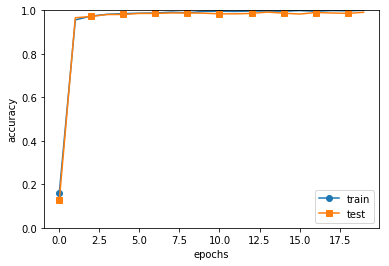

In [14]:
# coding: utf-8
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from ch07.simple_convnet import SimpleConvNet
from common.trainer import Trainer

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

訓練データの認識率は99.82%、テストデータの認識率は98.96%となった。
6章までで取り扱った全結合のニューラルネットワークではテストデータの認識率は80%から90%程度であったことを考えると、この比較的小さなネットワークにしてはとても高い認識率であることがわかる。

画像という空間的な形状のある特性を、CNNはうまく読み取ることができ、手書き数字認識においても高精度の認識を実現することができた。


## 感想

こんなに精度高く認識できるネットワークをこんなに簡単に実装できるというのは、本当に発明だと思った。
前回の勉強会で、画像解析に現れるフィルタとCNNのフィルタが似ているという話があったが、そこから着想を得て生まれたのがCNNなのかなと考えたが、本当に素晴らしい発明だと思う。